# Theory Plots
This notebook generates figures 1,2,3,4,5 of Data-agnostic Pruning at Initializationby Conserving Synaptic Flow.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import matplotlib as mpl
from matplotlib import rc

In [2]:
colors = {
    'rand' : plt.cm.tab10(7),
    'mag' : plt.cm.tab10(0),
    'cs' : plt.cm.tab10(2),
    'grasp' : plt.cm.tab10(1),
    'sf' : plt.cm.tab10(3),
}

## Figure 1: Layer-collapse leads to a sudden drop in accuracy.

{'mag': 2.75, 'cs': 3.5833333333333335, 'rand': 3.3333333333333335, 'grasp': 3.5833333333333335, 'sf': 5.916666666666667}


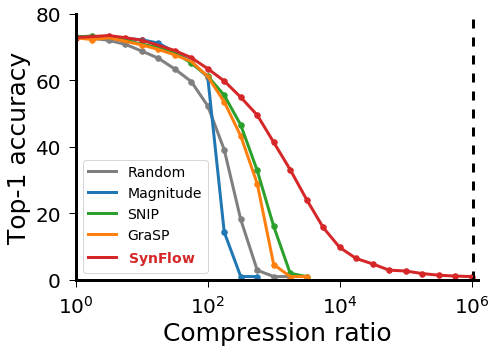

In [14]:
file = './data/0520_2020_cifar100_lottery_vgg16_bn/compression-rand-0.25-100.pkl'

comp = pd.read_pickle(file)
prunable = comp['prunable']
max_comp_ratio = np.sum(comp['size'][prunable])/14
max_comp_ratio



pruner_names = {'rand': 'Random', 'mag': 'Magnitude', 'cs': 'SNIP', 'grasp': 'GraSP', 'sf': '$\\bf{SynFlow}$'}

critical_comp = {'rand': 0, 'mag': 0, 'cs': 0, 'grasp': 0, 'sf': 0}

ratios = ['0.0','0.25','0.5','0.75','1.0','1.25','1.5','1.75','2.0','2.25','2.5','2.75','3.0','3.25','3.5','3.75','4.0','4.25','4.5','4.75','5.0','5.25','5.5','5.75','6.0']
pruners = np.array(['rand','mag','cs','grasp','sf'])

for pruner in pruners:
    for run_num,run in enumerate(['','_run2','_run3']):
        critical=0
        for ratio in ratios:        
            try:
                file = './data/0520_2020_cifar100_lottery_vgg16_bn'+run+'/compression-'+pruner+'-'+ratio+'-100.pkl'
                comp = pd.read_pickle(file)
                prunable = comp['prunable']
                if 14 == len(np.nonzero(comp[prunable]['sparsity'].to_numpy())[0]):
                    critical = float(ratio)

            except OSError:
                pass
        critical_comp[pruner] += critical
    critical_comp[pruner] = critical_comp[pruner]/3

print(critical_comp)


critical_comp = {'rand': 3.25, 'mag': 2.75, 'cs': 3.5, 'grasp': 3.5, 'sf': 6.0}

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as col
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

color = {'rand': 7, 'mag': 0, 'cs': 2, 'grasp': 1, 'sf': 3}

pruner_names = {'rand': 'Random', 'mag': 'Magnitude', 'cs': 'SNIP', 'grasp': 'GraSP', 'sf': '$\\bf{SynFlow}$'}#'SynFlow'}

lims  = [[0,100],[0,85],[0,67]]

exp_cifar10 =['cifar10_lottery_vgg11_bn',
            'cifar10_lottery_vgg16_bn',
            'cifar10_tiny_resnet18',
             'cifar10_tiny_wide_resnet18']
exp_cifar100=['cifar100_lottery_vgg11_bn',
            'cifar100_lottery_vgg16_bn',
            'cifar100_tiny_resnet18',
              'cifar100_tiny_wide_resnet18']
exp_tiny    =['tinyimagenet_vgg11_bn',
            'tinyimagenet_vgg16_bn',
            'tinyimagenet_resnet18',
            'tinyimagenet_wide_resnet18' ]
dir_path = './data/'
pruners = np.array(['rand','mag','cs','grasp','sf'])


fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ratios = np.array(['0.0','0.25','0.5','0.75','1.0','1.25','1.5','1.75','2.0','2.25','2.5','2.75','3.0','3.25','3.5','3.75','4.0','4.25','4.5','4.75','5.0','5.25','5.5','5.75','6.0'])
x_ratios = np.linspace(0,6,len(ratios))



ax.plot([max_comp_ratio, max_comp_ratio], [0,80] , color='k' ,ls=(0,(3,3)), lw=3, alpha=1)

for head in ['0520_2020_']:
    expid = 'cifar100_lottery_vgg16_bn'

    ymin = 100
    ymax = 0
    for l, pruner in enumerate(pruners):
        acc=np.zeros([3,len(ratios)])
        for run_num,run in enumerate(['','_run2','_run3']):
            experimentid = head+expid+run
            # setup main and zoom plot
            # get data
            speedup = np.zeros(len(ratios))

            for i,ratio in enumerate(ratios[:int(critical_comp[pruner]*4)+1]):
                try:
                    train_result_file = dir_path+experimentid+'/post-train-'+pruner+'-'+ratio+'-100.pkl'
                    compression_file =  dir_path+experimentid+'/compression-'+pruner+'-'+ratio+'-100.pkl'
                    train_result = pd.read_pickle(train_result_file)
                    compression = pd.read_pickle(compression_file)
                    train_epochs = len(train_result['top1_accuracy'])-1
                    acc[run_num,i] = np.max(train_result['top1_accuracy'])


                    prunable = compression['prunable'] == True
                    original_flops = np.sum( compression['flops'][prunable] )
                    pruned_flops = np.sum( compression['flops'][prunable]*compression['sparsity'][prunable] )

                except OSError:
                    pass

        acc[acc == 0] = 'nan'
        mean_acc = np.mean(acc, axis=0)
        mean_acc = np.array(mean_acc)
        ymax = max(max(mean_acc[0:len(ratios)//2 + 1]), ymax)

        # main plot
        ax.plot(10**x_ratios, mean_acc, color=colors[pruner], label=pruner_names[pruner], lw=3)
        ax.scatter(10**x_ratios, mean_acc, color=colors[pruner], s=30)

        ax.set_xscale('log')
        ax.set_xlim(1,max_comp_ratio+200000)
        ax.set_ylim([0,80])

    ax.tick_params(which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.0,pad=8,labelsize=20)
    ax.set_xlabel('Compression ratio', size=25)
    ax.set_ylabel('Top-1 accuracy', size=25)
    
    l = ax.legend(fontsize=14, loc='lower left')

    l.get_texts()[-1].set_color(plt.cm.tab10(3))


    # boundary and zoom box
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)
    ax.spines["right"].set_linestyle((0,(3,3)))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.subplots_adjust(hspace=0.2)
fig.tight_layout()
fig.show()
plt.savefig('./Plots/Fig1.pdf', bbox_inches="tight")

## Figure 2: Where does layer-collapse occur?

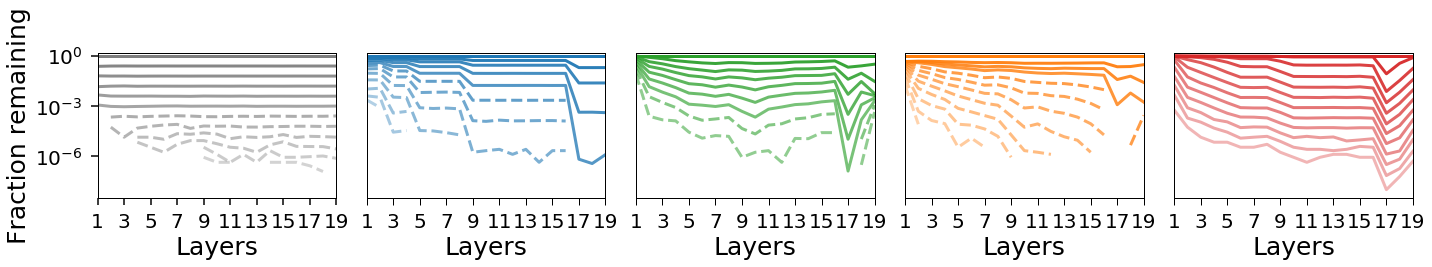

In [15]:
pepochs = {
    'rand': '1',
    'mag': '1',
    'cs': '1',
    'grasp': '1',
    'capacity': '0',
    'sf': '100'
}

dir_path = './data/'

pruners = ['rand', 'mag', 'cs', 'grasp', 'sf']

def zero_to_nan(values):
    return [float('nan') if x==0 else x for x in values]

expid = 'imagenet_vgg19_init'
# Setup Plot
fig, axs = plt.subplots(1, 5, figsize=(20, 3.5), sharey='row', sharex=True)

# Total Layer Score
for i, pruner in enumerate(pruners):
    ax = axs[i%5]
    #ax.set_title(pruner, size=20)
    ax.set_xlabel('Layers', size=25)
    if i ==0:
        ax.set_ylabel('Fraction remaining', size=25)
    ax.set_yscale('log')
    ax.set_xlim([1, 19])
    ax.set_ylim([10**(-8.5), 10**(0.2)])
    for j in np.arange(0,24,2):
        compression = pd.read_pickle(dir_path+expid+'/compression-'+pruner+'-'+str(j)+'-'+pepochs[pruner]+'.pkl')
        prunable = compression['prunable']==True
        weight   = compression['param']=='weight'
        sparsity = compression[np.logical_and(prunable,weight)]['sparsity']
        sparsity = np.array(sparsity)

        if np.sum( sparsity == 0 ) ==0:
            ax.plot( np.arange(len(sparsity))+1, sparsity, lw=3, color=colors[pruner],alpha=1-0.6*j/20)
        else:
            sparsity = zero_to_nan(sparsity)
            ax.plot( np.arange(len(sparsity))+1, sparsity, lw=3, color=colors[pruner], ls='--',alpha=1-0.6*j/20)

    ax.spines["top"].set_linewidth(1)
    ax.spines["bottom"].set_linewidth(1)
    ax.spines["right"].set_linewidth(1)
    ax.spines["left"].set_linewidth(1)

    if i==0:
        ax.tick_params(axis="both", which="both", bottom=True, top=False,
                       labelbottom=True, left=True, right=False,
                       labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=20)
    else:
        ax.tick_params(axis="both", which="both", bottom=True, top=False,
               labelbottom=True, left=False, right=False,
               labelleft=False,direction='out',length=7,width=1.0,pad=8,labelsize=20)


    ax.set_xticks(np.arange(1,1+len(sparsity), 2))

fig.tight_layout()
plt.savefig('./Plots/Fig2.pdf', bbox_inches="tight")

## Figure 3: Neuron-wise conservation of score.

In [16]:
model_architecture = 'vgg19'
dataset = 'imagenet'
pretrained = False
directory = './data/unit_conservation/{}/{}'.format(dataset, model_architecture)
pruners = ['rand','mag','cs','grasp','sf']
unit_scores = []
for i, p in enumerate(pruners):
    unit_score = np.load('{}/{}-{}.npy'.format(directory, p, 'pretrained' if pretrained else 'initialization'))
    unit_scores.append(unit_score)

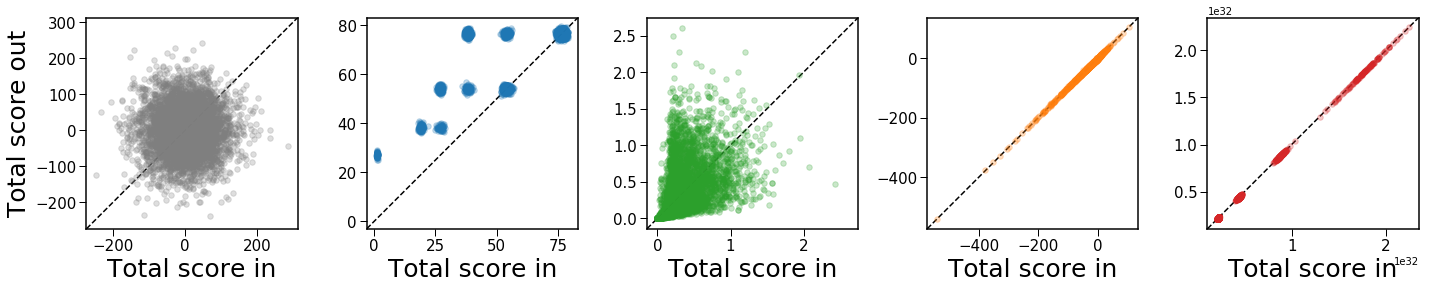

In [17]:
# Setup Plot
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

# Average Layer Score
for i, p in enumerate(pruners):
    ax = axs[i%5]
    
    # Set line width of axes
    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    
    # Set labels and titles
    ax.set_xlabel('Total score in', size=25)
    if i ==0:
        ax.set_ylabel('Total score out', size=25)
    in_score, out_score = unit_scores[i]
    
    # Hidden Unit Scatter
    ax.scatter(in_score, out_score, s=30, alpha=0.25, color=colors[p])
    
    # Conservation Line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k--', alpha=1.0, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.spines["top"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["right"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)
    ax.tick_params(axis="both", which="both", bottom=True, top=False,
           labelbottom=True, left=True, right=False,
           labelleft=True,direction='out',length=7,width=1.0,pad=3,labelsize=15)

fig.tight_layout()
plt.savefig('./Plots/Fig3.pdf', bbox_inches="tight")

## Figure 4: Inverse relationship between layer size and average layer score.

In [18]:
model_architecture = 'vgg19'
dataset = 'imagenet'
pretrained = False
directory = './data/layer_conservation/{}/{}'.format(dataset, model_architecture)
pruners = ['rand','mag','cs','grasp','sf']
average_scores = []
for i, p in enumerate(pruners):
    average_score = np.load('{}/{}-{}.npy'.format(directory, p, 'pretrained' if pretrained else 'initialization'))
    average_scores.append(average_score)
inv_size = np.load('{}/{}.npy'.format(directory, 'inv-size'))

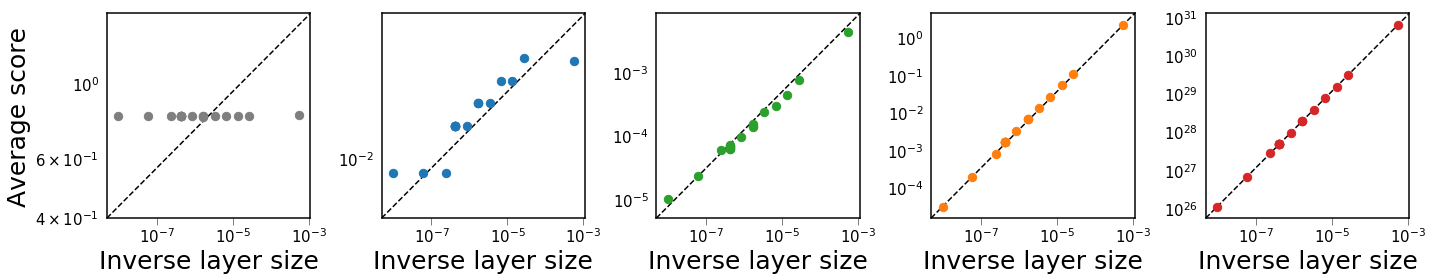

In [19]:
# Setup Plot
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

# Total Layer Score
for i, p in enumerate(pruners):
    ax = axs[i%5]
    
    # Set line width of axes
    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    
    # Set labels and titles
    ax.set_xlabel('Inverse layer size', size=25)
    if i == 0:
        ax.set_ylabel('Average score', size=25)
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    ax.scatter(inv_size, average_scores[i], s=70, color=colors[p])

    ax.set_xlim([0.5*np.min(inv_size), 2*np.max(inv_size)])
    ax.set_ylim([0.5*np.min(average_scores[i]), 2*np.max(average_scores[i])])

    ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--', zorder=0)
    ax.spines["top"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["right"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)
    ax.tick_params(axis="both", which="both", bottom=True, top=False,
           labelbottom=True, left=False, right=False,
           labelleft=True,direction='out',length=7,width=0.5,pad=1,labelsize=15)

fig.subplots_adjust(hspace=0.2)
fig.tight_layout()
plt.savefig('./Plots/Fig4.pdf', bbox_inches="tight")

## Figure 5a: Iteration is needed to avoid layer-collapse

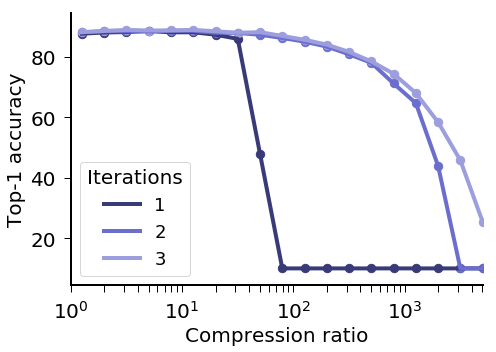

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
# Set line width of axes
ax.spines["top"].set_linewidth(0)
ax.spines["bottom"].set_linewidth(2)
ax.spines["right"].set_linewidth(0)
ax.spines["left"].set_linewidth(2)

# Turn on/off axes, ticks, change width, labelsize
ax.tick_params(axis="both", which="both", bottom=True, top=False,
               labelbottom=True, left=True, right=False,
               labelleft=True,direction='out',length=7,width=1.0,pad=8,labelsize=20)

cols = [plt.cm.tab20b(0), plt.cm.tab20b(2), plt.cm.tab20b(3)]
ratios = []
ratios_array = np.linspace(0.1,4.9,25)
for i in range(len(ratios_array)):
    ratios.append( str( np.around(ratios_array[i],2)) )
#ratios = ['3.1','3.3','3.5','3.7','3.9']
acc = np.zeros(len(ratios))
for itera in range(1,4):
    for i, comp in enumerate(ratios):
        try:
            file = './data/0529_2020_cifar10_lottery_vgg11_bn_lottery/performance-'+comp+'-50-'+str(itera)+'.pkl'
            acc[i] = np.max(pd.read_pickle(file)['top1_accuracy'])
            #print(i)
        except OSError:
            acc[i] = 'nan'
            pass
    plt.plot(10**ratios_array ,acc, lw=4, color=cols[itera-1], label=str(itera))#plt.cm.tab10(0), alpha=1-(itera-1)/3.5)
    plt.scatter(10**ratios_array ,acc, s=70, color=cols[itera-1])# color=plt.cm.tab10(0), alpha=1-(itera-1)/3.5)
plt.xscale('log')
plt.xlim(1,10**3.7)
plt.xlabel('Compression ratio', size=20)
plt.ylabel('Top-1 accuracy', size=20)

plt.rcParams['legend.title_fontsize'] = 20
plt.legend(fontsize=18, title='Iterations')
fig.tight_layout()
plt.savefig('./Plots/Fig5a.pdf', bbox_inches="tight")

## Figure 5b: IMP obtains conservation by training

In [21]:
model_architecture = 'vgg19'
model_class = 'lottery'
dataset = 'cifar10'
lr = 0.001
epochs = 100
verbose = True
directory = './data/lottery_layer_conservation/{}/{}'.format(dataset, model_architecture)
inv_size = np.load('{}/{}.npy'.format(directory,'inv-size'))
WT = np.load('{}/xavier_lr-{}_epochs-{}_WT.npy'.format(directory, lr, epochs))

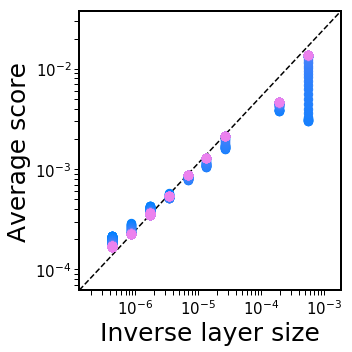

In [22]:
# Setup Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
# Set line width of axes
ax.spines["top"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)

# Set labels and titles
ax.set_xlabel('Inverse layer size', size=25)
ax.set_ylabel('Average score', size=25)
ax.set_yscale('log')
ax.set_xscale('log')

cmap = mpl.cm.get_cmap('cool')
num_points = len(WT)
for j in range(num_points):
    blue = np.array([0, 128, 255,255])/255
    pink = np.array([238, 130, 238,255])/255
    ax.scatter(inv_size, WT[j], s=70, color=blue+((j/num_points)*( pink-blue )))

xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.set_xlim([0.5*xlim[0], 2*xlim[1]])
ax.set_ylim([0.5*ylim[0], 2*ylim[1]])

ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--', zorder=0)

ax.tick_params(axis="both", which="both", bottom=True, top=False,
       labelbottom=True, left=True, right=False,
       labelleft=True,direction='out',length=5,width=1.0,pad=3,labelsize=15)


fig.subplots_adjust(hspace=0.2)
fig.tight_layout()
plt.savefig('Fig5b.pdf', bbox_inches="tight")

## Figure 6: SynFlow consistently outperforms other pruning methods.

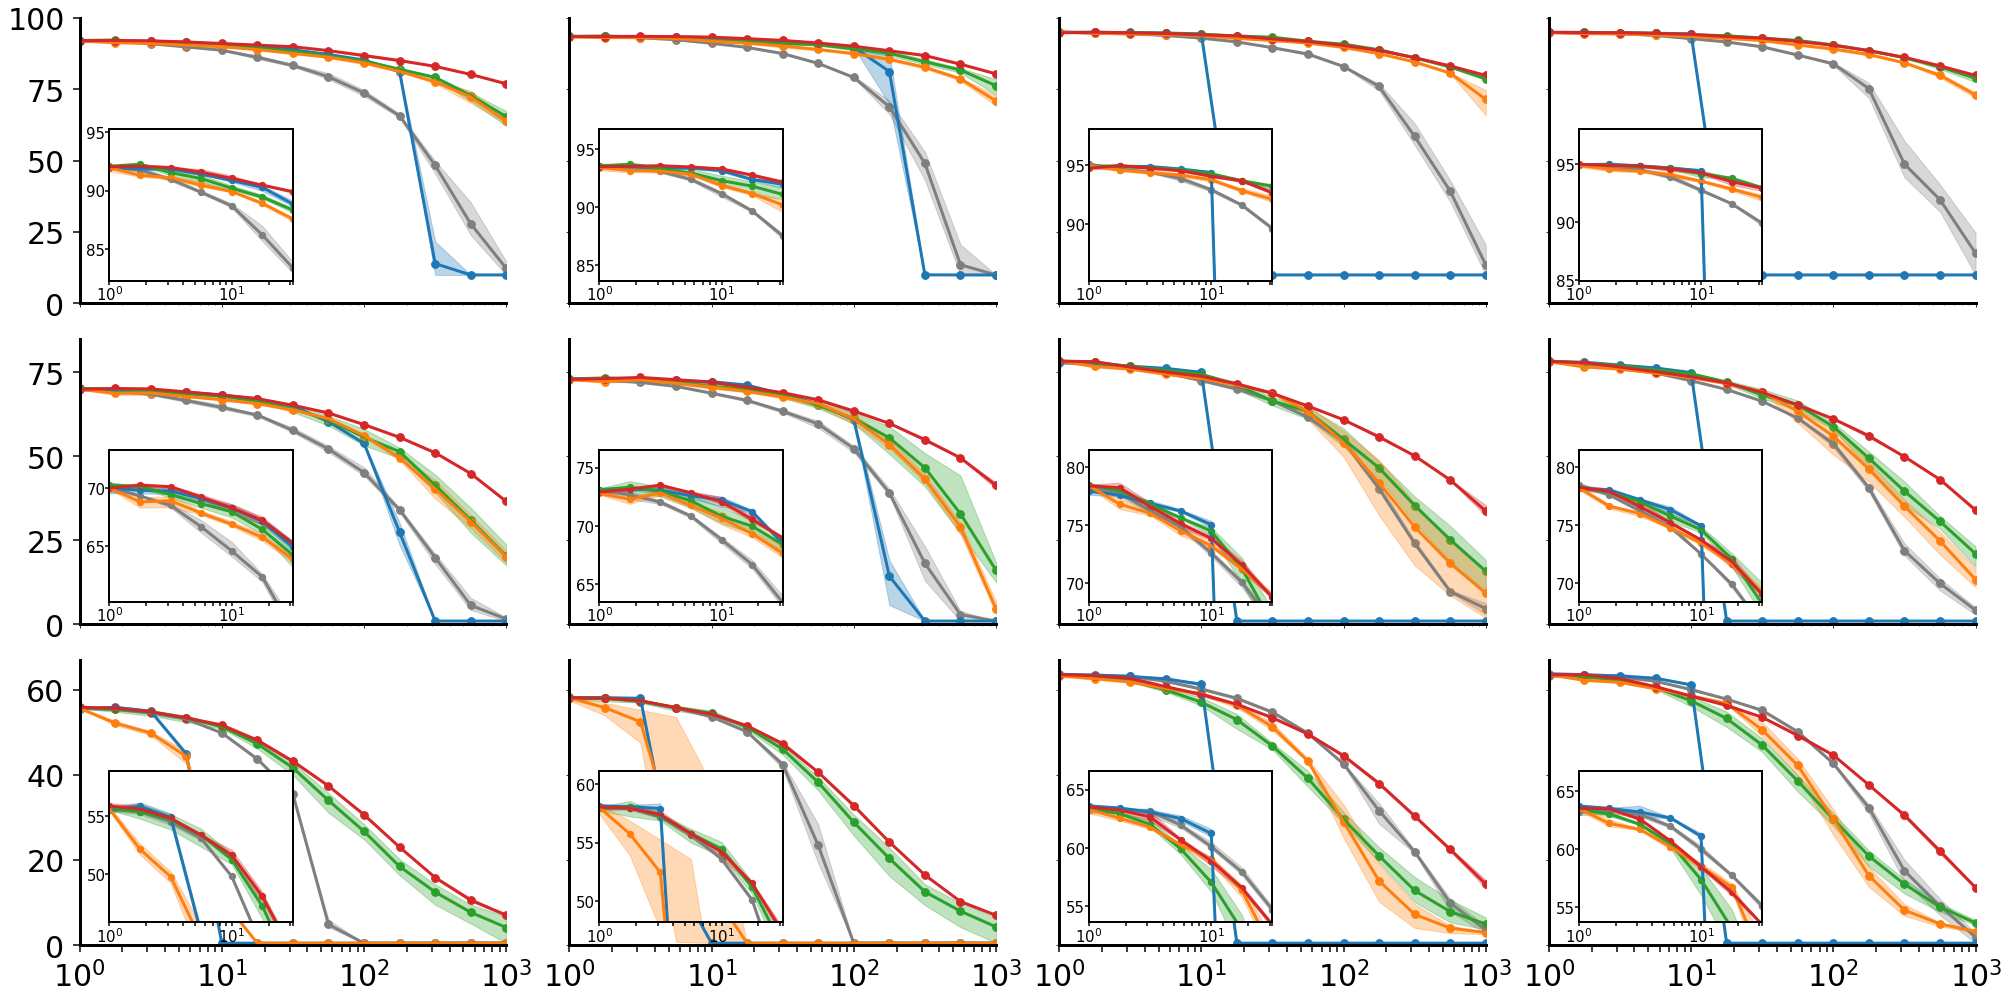

In [23]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as col
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

lims  = [[0,100],[0,85],[0,67]]

exp_cifar10 =['cifar10_lottery_vgg11_bn',
            'cifar10_lottery_vgg16_bn',
            'cifar10_tiny_resnet18',
             'cifar10_tiny_wide_resnet18']
exp_cifar100=['cifar100_lottery_vgg11_bn',
            'cifar100_lottery_vgg16_bn',
            'cifar100_tiny_resnet18',
              'cifar100_tiny_wide_resnet18']
exp_tiny    =['tinyimagenet_vgg11_bn',
            'tinyimagenet_vgg16_bn',
            'tinyimagenet_resnet18',
            'tinyimagenet_wide_resnet18' ]

pruners = np.array(['rand','mag','cs','grasp','sf'])

mode='num_params'


ratios = ['0.0','0.25','0.5','0.75','1.0','1.25','1.5','1.75','2.0','2.25','2.5','2.75','3.0']
x_ratios = np.linspace(0,3,len(ratios))


fig, axs = plt.subplots(3, 4, figsize=(28, 14), sharey='row', sharex=True)
for k,expids in enumerate([exp_cifar10, exp_cifar100,exp_tiny]):
    for j,expid in enumerate(expids):

        ax = axs[k,j%4]
        axins = ax.inset_axes([0.07, 0.08, 0.43, 0.53])
        ymin = 100
        ymax = 0

        for l, pruner in enumerate(pruners):
            acc=np.load('./data/Accuracy_CompRatio/'+expid+'-'+pruner+'.npy')
            mean_acc = np.nanmean(acc, axis=0)
            mean_acc = np.array(mean_acc)
            ymax = max(max(mean_acc[0:len(ratios)//2 + 1]), ymax)

            if mode == 'num_params':
                # main plot
                ax.plot(10**x_ratios, mean_acc, color=colors[pruner], label=pruner, lw=3)
                ax.scatter(10**x_ratios, mean_acc, color=colors[pruner], s=60)
                ax.fill_between(10**x_ratios, np.min(acc, axis=0), np.max(acc, axis=0),color=colors[pruner], facecolor=colors[pruner], alpha=0.3)

                # zoom plot
                axins.plot(10**x_ratios, mean_acc, color=colors[pruner], label=pruner, lw=3)
                axins.scatter(10**x_ratios, mean_acc, color=colors[pruner], s=40)
                axins.fill_between(10**x_ratios, np.min(acc, axis=0), np.max(acc, axis=0), color=colors[pruner], facecolor=plt.cm.tab10(color[pruner]), alpha=0.3)

            # main axis
            ax.set_xscale('log')
            ax.set_xlim(1,1000)
            ax.set_ylim(lims[k])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

            # zoom axis
            axins.set_xscale('log')
            axins.set_xticks([1,10,10**1.5])
            axins.set_xlim(1, 10**1.5)
            axins.set_ylim(ymax-10.0, ymax+3.0)
            axins.tick_params(which="both", bottom=True, top=False,
                           labelbottom=True, left=True, right=False,
                           labelleft=True,direction='out',length=4,width=1.5,pad=0,labelsize=15)      

        # tick params and axis labels
        if j == 0:
            ax.tick_params(axis="y", which="both", bottom=True, top=False,
                           labelbottom=True, left=True, right=False,
                           labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=30)
        if k == 2:
            ax.tick_params(axis="x", which="both", bottom=True, top=False,
                           labelbottom=True, left=True, right=False,
                           labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=30)


        # boundary and zoom box
        for dir in ["top", "bottom", "right", "left"]:
            ax.spines[dir].set_linewidth(3)
            axins.spines[dir].set_linewidth(2)

fig.subplots_adjust(hspace=0.2)
fig.tight_layout()
fig.show()
plt.savefig('./Plots/Fig6.pdf', bbox_inches="tight")

## Figure 7a: Linear compression schedule

In [25]:
model_architecture = 'vgg19'
model_class = 'imagenet'
dataset = 'imagenet'
pretrained = False
directory = './data/flow/{}/{}'.format(dataset, model_architecture)
results = np.load('{}/ratios.npy'.format(directory))
exponents = [0.0,0.5,1.0,1.5,2.0,2.5,3.0]
iterations = [1,10,20,30,40,50,60,70,80,90,100]

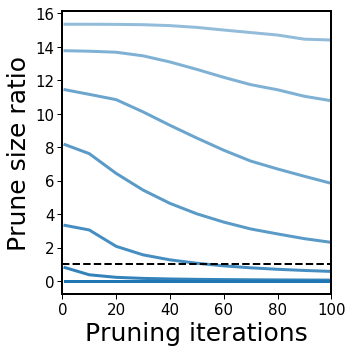

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.spines["top"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.tick_params(axis="both", which="both", bottom=True, top=False,
   labelbottom=True, left=True, right=False,
   labelleft=True,direction='out',length=5,width=1.0,pad=3,labelsize=15)


for j, exp in enumerate(exponents):
    ax.plot(iterations, results[0][j], color=plt.cm.tab10(0), alpha=1.0-0.6*j/len(exponents), lw=3)

ax.set_xlim(0,100)
ax.plot(ax.get_xlim(), [1.0, 1.0], color='k', ls='--', lw=2)

ax.set_xlabel('Pruning iterations', size=25)
ax.set_ylabel('Prune size ratio', size=25)


fig.subplots_adjust(hspace=0.2)
fig.tight_layout()
plt.savefig('Fig7a.pdf', bbox_inches="tight")

## Figure 7a: Linear compression schedule

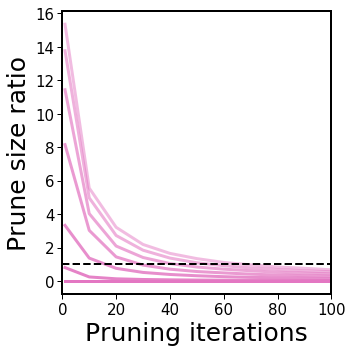

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.spines["top"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
ax.spines["right"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.tick_params(axis="both", which="both", bottom=True, top=False,
   labelbottom=True, left=True, right=False,
   labelleft=True,direction='out',length=5,width=1.0,pad=3,labelsize=15)


for j, exp in enumerate(exponents):
    ax.plot(iterations, results[1][j], color=plt.cm.tab10(6), alpha=1.0-0.6*j/len(exponents), lw=3)

ax.set_xlim(0,100)
ax.plot(ax.get_xlim(), [1.0, 1.0], color='k', ls='--', lw=2)

ax.set_xlabel('Pruning iterations', size=25)
ax.set_ylabel('Prune size ratio', size=25)


fig.subplots_adjust(hspace=0.2)
fig.tight_layout()
plt.savefig('Fig7b.pdf', bbox_inches="tight")